In [1]:
%matplotlib inline



# Repairing artifacts with ICA

This tutorial covers the basics of independent components analysis (ICA) and
shows how ICA can be used for artifact repair; an extended example illustrates
repair of ocular and heartbeat artifacts. For conceptual background on ICA, see
`this scikit-learn tutorial
<sphx_glr_auto_examples_decomposition_plot_ica_blind_source_separation.py>`.

We begin as always by importing the necessary Python modules and loading some
`example data <sample-dataset>`. Because ICA can be computationally
intense, we'll also crop the data to 60 seconds; and to save ourselves from
repeatedly typing ``mne.preprocessing`` we'll directly import a few functions
and classes from that submodule:


In [2]:
import os
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.).pick_types(meg='mag', eeg=True, stim=True, eog=True)
raw.load_data()

Opening raw data file /home/shivam/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 171 x 9010 (60.0 s), ~14.8 MB, data loaded>

<div class="alert alert-info"><h4>Note</h4><p>Before applying ICA (or any artifact repair strategy), be sure to observe
    the artifacts in your data to make sure you choose the right repair tool.
    Sometimes the right tool is no tool at all — if the artifacts are small
    enough you may not even need to repair them to get good analysis results.
    See `tut-artifact-overview` for guidance on detecting and
    visualizing various types of artifact.</p></div>

## What is ICA?

Independent components analysis (ICA) is a technique for estimating
independent source signals from a set of recordings in which the source
signals were mixed together in unknown ratios. A common example of this is
the problem of `blind source separation`_: with 3 musical instruments playing
in the same room, and 3 microphones recording the performance (each picking
up all 3 instruments, but at varying levels), can you somehow "unmix" the
signals recorded by the 3 microphones so that you end up with a separate
"recording" isolating the sound of each instrument?

It is not hard to see how this analogy applies to EEG/MEG analysis: there are
many "microphones" (sensor channels) simultaneously recording many
"instruments" (blinks, heartbeats, activity in different areas of the brain,
muscular activity from jaw clenching or swallowing, etc). As long as these
various source signals are `statistically independent`_ and non-gaussian, it
is usually possible to separate the sources using ICA, and then re-construct
the sensor signals after excluding the sources that are unwanted.


### ICA in MNE-Python

.. sidebar:: ICA and dimensionality reduction

    If you want to perform ICA with *no* dimensionality reduction (other than
    the number of Independent Components (ICs) given in ``n_components``, and
    any subsequent exclusion of ICs you specify in ``ICA.exclude``), simply
    pass ``n_components``.

    However, if you *do* want to reduce dimensionality, consider this
    example: if you have 300 sensor channels and you set ``n_components=50``
    during instantiation and pass ``n_pca_components=None`` to
    `~mne.preprocessing.ICA.apply`, then the the first 50
    PCs are sent to the ICA algorithm (yielding 50 ICs), and during
    reconstruction `~mne.preprocessing.ICA.apply` will use the 50 ICs
    plus PCs number 51-300 (the full PCA residual). If instead you specify
    ``n_pca_components=120`` in `~mne.preprocessing.ICA.apply`, it will
    reconstruct using the 50 ICs plus the first 70 PCs in the PCA residual
    (numbers 51-120), thus discarding the smallest 180 components.

    **If you have previously been using EEGLAB**'s ``runica()`` and are
    looking for the equivalent of its ``'pca', n`` option to reduce
    dimensionality, set ``n_components=n`` during initialization and pass
    ``n_pca_components=n`` to `~mne.preprocessing.ICA.apply`.

MNE-Python implements three different ICA algorithms: ``fastica`` (the
default), ``picard``, and ``infomax``. FastICA and Infomax are both in fairly
widespread use; Picard is a newer (2017) algorithm that is expected to
converge faster than FastICA and Infomax, and is more robust than other
algorithms in cases where the sources are not completely independent, which
typically happens with real EEG/MEG data. See
:footcite:`AblinEtAl2018` for more information.

The ICA interface in MNE-Python is similar to the interface in
`scikit-learn`_: some general parameters are specified when creating an
`~mne.preprocessing.ICA` object, then the `~mne.preprocessing.ICA` object is
fit to the data using its `~mne.preprocessing.ICA.fit` method. The results of
the fitting are added to the `~mne.preprocessing.ICA` object as attributes
that end in an underscore (``_``), such as ``ica.mixing_matrix_`` and
``ica.unmixing_matrix_``. After fitting, the ICA component(s) that you want
to remove must be chosen, and the ICA fit must then be applied to the
`~mne.io.Raw` or `~mne.Epochs` object using the `~mne.preprocessing.ICA`
object's `~mne.preprocessing.ICA.apply` method.

As is typically done with ICA, the data are first scaled to unit variance and
whitened using principal components analysis (PCA) before performing the ICA
decomposition. This is a two-stage process:

1. To deal with different channel types having different units
   (e.g., Volts for EEG and Tesla for MEG), data must be pre-whitened.
   If ``noise_cov=None`` (default), all data of a given channel type is
   scaled by the standard deviation across all channels. If ``noise_cov`` is
   a `~mne.Covariance`, the channels are pre-whitened using the covariance.
2. The pre-whitened data are then decomposed using PCA.

From the resulting principal components (PCs), the first ``n_components`` are
then passed to the ICA algorithm if ``n_components`` is an integer number.
It can also be a float between 0 and 1, specifying the **fraction** of
explained variance that the PCs should capture; the appropriate number of
PCs (i.e., just as many PCs as are required to explain the given fraction
of total variance) is then passed to the ICA.

After visualizing the Independent Components (ICs) and excluding any that
capture artifacts you want to repair, the sensor signal can be reconstructed
using the `~mne.preprocessing.ICA` object's
`~mne.preprocessing.ICA.apply` method. By default, signal
reconstruction uses all of the ICs (less any ICs listed in ``ICA.exclude``)
plus all of the PCs that were not included in the ICA decomposition (i.e.,
the "PCA residual"). If you want to reduce the number of components used at
the reconstruction stage, it is controlled by the ``n_pca_components``
parameter (which will in turn reduce the rank of your data; by default
``n_pca_components=None`` resulting in no additional dimensionality
reduction). The fitting and reconstruction procedures and the
parameters that control dimensionality at various stages are summarized in
the diagram below:


.. raw:: html

   <a href=
    "../../_images/graphviz-7483cb1cf41f06e2a4ef451b17f073dbe584ba30.png">

.. graphviz:: ../../_static/diagrams/ica.dot
   :alt: Diagram of ICA procedure in MNE-Python
   :align: left

.. raw:: html

   </a>

See the Notes section of the `~mne.preprocessing.ICA` documentation
for further details. Next we'll walk through an extended example that
illustrates each of these steps in greater detail.

## Example: EOG and ECG artifact repair

### Visualizing the artifacts

Let's begin by visualizing the artifacts that we want to repair. In this
dataset they are big enough to see easily in the raw data:



Using matplotlib as 2D backend.


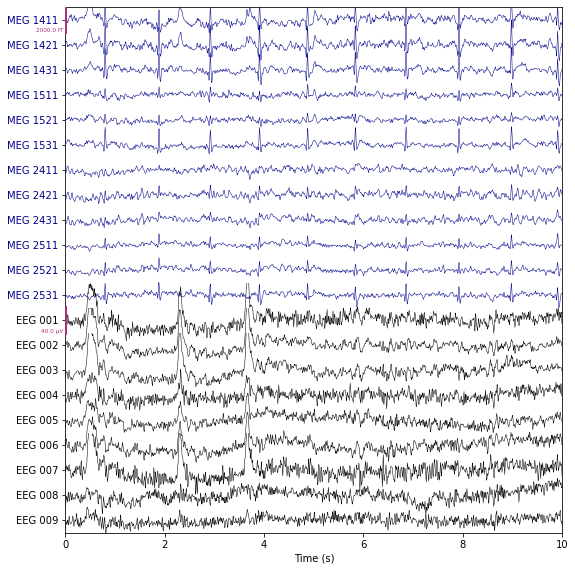

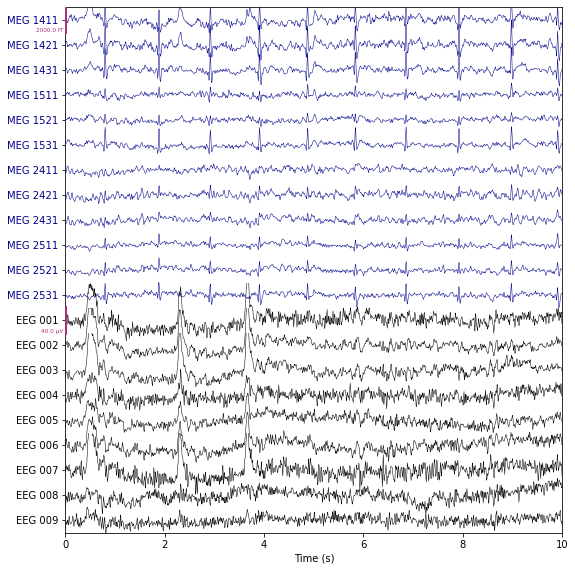

In [3]:
# pick some channels that clearly show heartbeats and blinks
regexp = r'(MEG [12][45][123]1|EEG 00.)'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
         show_scrollbars=False)

We can get a summary of how the ocular artifact manifests across each channel
type using `~mne.preprocessing.create_eog_epochs` like we did in the
`tut-artifact-overview` tutorial:



Using EOG channel: EOG 061
EOG channel index for this subject is: [170]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 10 events and 151 original time points ...
0 bad epochs dropped
Applying baseline c

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


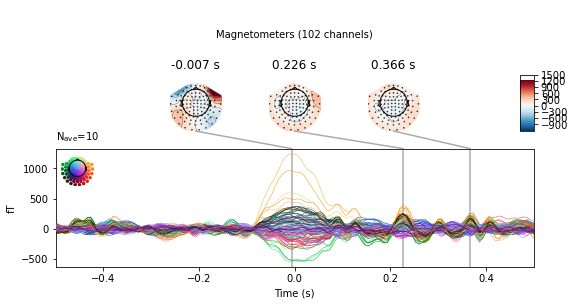

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


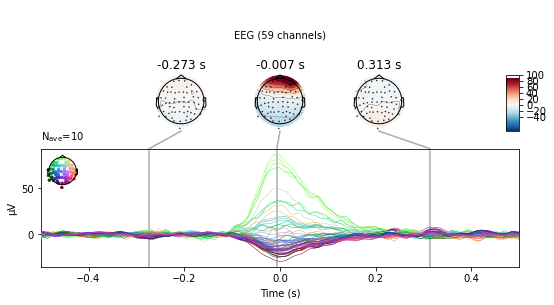

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [4]:
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Now we'll do the same for the heartbeat artifacts, using
`~mne.preprocessing.create_ecg_epochs`:



Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 sec)

Number of ECG events detected : 59 (average pulse 58 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 59 events and 151 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...
Removing projector <Projection | Aver

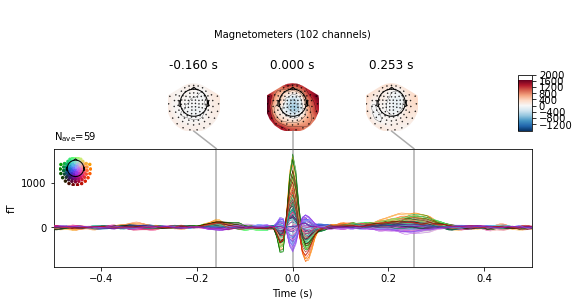

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


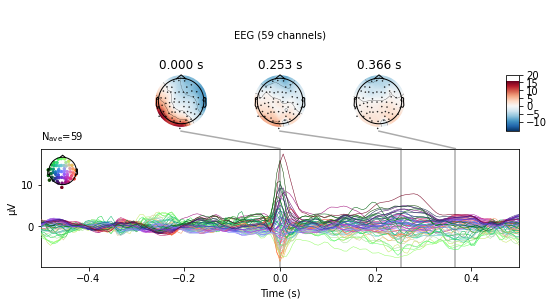

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [5]:
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

### Filtering to remove slow drifts

Before we run the ICA, an important step is filtering the data to remove
low-frequency drifts, which can negatively affect the quality of the ICA fit.
The slow drifts are problematic because they reduce the independence of the
assumed-to-be-independent sources (e.g., during a slow upward drift, the
neural, heartbeat, blink, and other muscular sources will all tend to have
higher values), making it harder for the algorithm to find an accurate
solution. A high-pass filter with 1 Hz cutoff frequency is recommended.
However, because filtering is a linear operation, the ICA solution found from
the filtered signal can be applied to the unfiltered signal (see
:footcite:`WinklerEtAl2015` for
more information), so we'll keep a copy of the unfiltered
`~mne.io.Raw` object around so we can apply the ICA solution to it
later.



In [6]:
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    0.1s finished


### Fitting and plotting the ICA solution

.. sidebar:: Ignoring the time domain

    The ICA algorithms implemented in MNE-Python find patterns across
    channels, but ignore the time domain. This means you can compute ICA on
    discontinuous `~mne.Epochs` or `~mne.Evoked` objects (not
    just continuous `~mne.io.Raw` objects), or only use every Nth
    sample by passing the ``decim`` parameter to ``ICA.fit()``.

    .. note:: `~mne.Epochs` used for fitting ICA should not be
              baseline-corrected. Because cleaning the data via ICA may
              introduce DC offsets, we suggest to baseline correct your data
              **after** cleaning (and not before), should you require
              baseline correction.

Now we're ready to set up and fit the ICA. Since we know (from observing our
raw data) that the EOG and ECG artifacts are fairly strong, we would expect
those artifacts to be captured in the first few dimensions of the PCA
decomposition that happens before the ICA. Therefore, we probably don't need
a huge number of components to do a good job of isolating our artifacts
(though it is usually preferable to include more components for a more
accurate solution). As a first guess, we'll run ICA with ``n_components=15``
(use only the first 15 PCA components to compute the ICA decomposition) — a
very small number given that our data has over 300 channels, but with the
advantage that it will run quickly and we will able to tell easily whether it
worked or not (because we already know what the EOG / ECG artifacts should
look like).

ICA fitting is not deterministic (e.g., the components may get a sign
flip on different runs, or may not always be returned in the same order), so
we'll also specify a `random seed`_ so that we get identical results each
time this tutorial is built by our web servers.



In [7]:
ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 161 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


Method,fastica
Fit,22 iterations on raw data (9010 samples)
ICA components,15
Available PCA components,161
Channel types,"mag, eeg"
ICA components marked for exclusion,—


Some optional parameters that we could have passed to the
`~mne.preprocessing.ICA.fit` method include ``decim`` (to use only
every Nth sample in computing the ICs, which can yield a considerable
speed-up) and ``reject`` (for providing a rejection dictionary for maximum
acceptable peak-to-peak amplitudes for each channel type, just like we used
when creating epoched data in the `tut-overview` tutorial).

Now we can examine the ICs to see what they captured.
`~mne.preprocessing.ICA.plot_sources` will show the time series of the
ICs. Note that in our call to `~mne.preprocessing.ICA.plot_sources` we
can use the original, unfiltered `~mne.io.Raw` object:



In [8]:
ica.get_components().shape

(161, 15)

In [ ]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

Here we can pretty clearly see that the first component (``ICA000``) captures
the EOG signal quite well, and the second component (``ICA001``) looks a lot
like [a heartbeat](qrs_) (for more info on visually identifying Independent
Components, `this EEGLAB tutorial`_ is a good resource). We can also
visualize the scalp field distribution of each component using
`~mne.preprocessing.ICA.plot_components`. These are interpolated based
on the values in the ICA mixing matrix:



In [ ]:
ica.plot_components()

<div class="alert alert-info"><h4>Note</h4><p>`~mne.preprocessing.ICA.plot_components` (which plots the scalp
    field topographies for each component) has an optional ``inst`` parameter
    that takes an instance of `~mne.io.Raw` or `~mne.Epochs`.
    Passing ``inst`` makes the scalp topographies interactive: clicking one
    will bring up a diagnostic `~mne.preprocessing.ICA.plot_properties`
    window (see below) for that component.</p></div>

In the plots above it's fairly obvious which ICs are capturing our EOG and
ECG artifacts, but there are additional ways visualize them anyway just to
be sure. First, we can plot an overlay of the original signal against the
reconstructed signal with the artifactual ICs excluded, using
`~mne.preprocessing.ICA.plot_overlay`:



In [ ]:
# blinks
ica.plot_overlay(raw, exclude=[0], picks='eeg')
# heartbeats
ica.plot_overlay(raw, exclude=[1], picks='mag')

We can also plot some diagnostics of each IC using
`~mne.preprocessing.ICA.plot_properties`:



In [ ]:
ica.plot_properties(raw, picks=[0, 1])

In the remaining sections, we'll look at different ways of choosing which ICs
to exclude prior to reconstructing the sensor signals.


### Selecting ICA components manually

Once we're certain which components we want to exclude, we can specify that
manually by setting the ``ica.exclude`` attribute. Similar to marking bad
channels, merely setting ``ica.exclude`` doesn't do anything immediately (it
just adds the excluded ICs to a list that will get used later when it's
needed). Once the exclusions have been set, ICA methods like
`~mne.preprocessing.ICA.plot_overlay` will exclude those component(s)
even if no ``exclude`` parameter is passed, and the list of excluded
components will be preserved when using `mne.preprocessing.ICA.save`
and `mne.preprocessing.read_ica`.



In [ ]:
ica.exclude = [0, 1]  # indices chosen based on various plots above

Now that the exclusions have been set, we can reconstruct the sensor signals
with artifacts removed using the `~mne.preprocessing.ICA.apply` method
(remember, we're applying the ICA solution from the *filtered* data to the
original *unfiltered* signal). Plotting the original raw data alongside the
reconstructed data shows that the heartbeat and blink artifacts are repaired.



In [ ]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
         show_scrollbars=False)
reconst_raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
                 show_scrollbars=False)
del reconst_raw

### Using an EOG channel to select ICA components

It may have seemed easy to review the plots and manually select which ICs to
exclude, but when processing dozens or hundreds of subjects this can become
a tedious, rate-limiting step in the analysis pipeline. One alternative is to
use dedicated EOG or ECG sensors as a "pattern" to check the ICs against, and
automatically mark for exclusion any ICs that match the EOG/ECG pattern. Here
we'll use `~mne.preprocessing.ICA.find_bads_eog` to automatically find
the ICs that best match the EOG signal, then use
`~mne.preprocessing.ICA.plot_scores` along with our other plotting
functions to see which ICs it picked. We'll start by resetting
``ica.exclude`` back to an empty list:



In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

Note that above we used `~mne.preprocessing.ICA.plot_sources` on both
the original `~mne.io.Raw` instance and also on an
`~mne.Evoked` instance of the extracted EOG artifacts. This can be
another way to confirm that `~mne.preprocessing.ICA.find_bads_eog` has
identified the correct components.


### Using a simulated channel to select ICA components

If you don't have an EOG channel,
`~mne.preprocessing.ICA.find_bads_eog` has a ``ch_name`` parameter that
you can use as a proxy for EOG. You can use a single channel, or create a
bipolar reference from frontal EEG sensors and use that as virtual EOG
channel. This carries a risk however: you must hope that the frontal EEG
channels only reflect EOG and not brain dynamics in the prefrontal cortex (or
you must not care about those prefrontal signals).

For ECG, it is easier: `~mne.preprocessing.ICA.find_bads_ecg` can use
cross-channel averaging of magnetometer or gradiometer channels to construct
a virtual ECG channel, so if you have MEG channels it is usually not
necessary to pass a specific channel name.
`~mne.preprocessing.ICA.find_bads_ecg` also has two options for its
``method`` parameter: ``'ctps'`` (cross-trial phase statistics
:footcite:`DammersEtAl2008`) and
``'correlation'`` (Pearson correlation between data and ECG channel).



In [ ]:
ica.exclude = []
# find which ICs match the ECG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='correlation',
                                            threshold='auto')
ica.exclude = ecg_indices

# barplot of ICA component "ECG match" scores
ica.plot_scores(ecg_scores)

# plot diagnostics
ica.plot_properties(raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica.plot_sources(ecg_evoked)

The last of these plots is especially useful: it shows us that the heartbeat
artifact is coming through on *two* ICs, and we've only caught one of them.
In fact, if we look closely at the output of
`~mne.preprocessing.ICA.plot_sources` (online, you can right-click →
"view image" to zoom in), it looks like ``ICA014`` has a weak periodic
component that is in-phase with ``ICA001``. It might be worthwhile to re-run
the ICA with more components to see if that second heartbeat artifact
resolves out a little better:



In [ ]:
# refit the ICA with 30 components this time
new_ica = ICA(n_components=30, max_iter='auto', random_state=97)
new_ica.fit(filt_raw)

# find which ICs match the ECG pattern
ecg_indices, ecg_scores = new_ica.find_bads_ecg(raw, method='correlation',
                                                threshold='auto')
new_ica.exclude = ecg_indices

# barplot of ICA component "ECG match" scores
new_ica.plot_scores(ecg_scores)

# plot diagnostics
new_ica.plot_properties(raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
new_ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
new_ica.plot_sources(ecg_evoked)

Much better! Now we've captured both ICs that are reflecting the heartbeat
artifact (and as a result, we got two diagnostic plots: one for each IC that
reflects the heartbeat). This demonstrates the value of checking the results
of automated approaches like `~mne.preprocessing.ICA.find_bads_ecg`
before accepting them.



In [ ]:
# clean up memory before moving on
del raw, ica, new_ica

### Selecting ICA components using template matching

When dealing with multiple subjects, it is also possible to manually select
an IC for exclusion on one subject, and then use that component as a
*template* for selecting which ICs to exclude from other subjects' data,
using `mne.preprocessing.corrmap` :footcite:`CamposViolaEtAl2009`.
The idea behind `~mne.preprocessing.corrmap` is that the artifact patterns
are similar
enough across subjects that corresponding ICs can be identified by
correlating the ICs from each ICA solution with a common template, and
picking the ICs with the highest correlation strength.
`~mne.preprocessing.corrmap` takes a list of ICA solutions, and a
``template`` parameter that specifies which ICA object and which component
within it to use as a template.

Since our sample dataset only contains data from one subject, we'll use a
different dataset with multiple subjects: the EEGBCI dataset
:footcite:`SchalkEtAl2004,GoldbergerEtAl2000`. The
dataset has 109 subjects, we'll just download one run (a left/right hand
movement task) from each of the first 4 subjects:



In [ ]:
mapping = {
    'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2',
    'Fc4.': 'FC4', 'Fc6.': 'FC6', 'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1',
    'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6', 'Cp5.': 'CP5',
    'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4',
    'Cp6.': 'CP6', 'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7',
    'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8', 'F7..': 'F7',
    'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2',
    'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8', 'Ft7.': 'FT7', 'Ft8.': 'FT8',
    'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7',
    'Tp8.': 'TP8', 'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1',
    'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
    'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8',
    'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
}

raws = list()
icas = list()

for subj in range(4):
    # EEGBCI subjects are 1-indexed; run 3 is a left/right hand movement task
    fname = mne.datasets.eegbci.load_data(subj + 1, runs=[3])[0]
    raw = mne.io.read_raw_edf(fname).load_data().resample(50)
    # remove trailing `.` from channel names so we can set montage
    raw.rename_channels(mapping)
    raw.set_montage('standard_1005')
    # high-pass filter
    raw_filt = raw.copy().load_data().filter(l_freq=1., h_freq=None)
    # fit ICA, using low max_iter for speed
    ica = ICA(n_components=30, max_iter=100, random_state=97)
    ica.fit(raw_filt, verbose='error')
    raws.append(raw)
    icas.append(ica)

Now let's run `~mne.preprocessing.corrmap`:



In [ ]:
# use the first subject as template; use Fpz as proxy for EOG
raw = raws[0]
ica = icas[0]
eog_inds, eog_scores = ica.find_bads_eog(raw, ch_name='Fpz')
corrmap(icas, template=(0, eog_inds[0]))

The first figure shows the template map, while the second figure shows all
the maps that were considered a "match" for the template (including the
template itself). There is one match for each subject, but it's a good idea
to also double-check the ICA sources for each subject:



In [ ]:
for index, (ica, raw) in enumerate(zip(icas, raws)):
    with mne.viz.use_browser_backend('matplotlib'):
        fig = ica.plot_sources(raw, show_scrollbars=False)
    fig.subplots_adjust(top=0.9)  # make space for title
    fig.suptitle('Subject {}'.format(index))

Notice that subjects 2 and 3 each seem to have *two* ICs that reflect ocular
activity (components ``ICA000`` and ``ICA002``), but only one was caught by
`~mne.preprocessing.corrmap`. Let's try setting the threshold manually:



In [ ]:
corrmap(icas, template=(0, eog_inds[0]), threshold=0.9)

This time it found 2 ICs for each of subjects 2 and 3 (which is good).
At this point we'll re-run `~mne.preprocessing.corrmap` with
parameters ``label='blink', plot=False`` to *label* the ICs from each subject
that capture the blink artifacts (without plotting them again).



In [ ]:
corrmap(icas, template=(0, eog_inds[0]), threshold=0.9, label='blink',
        plot=False)
print([ica.labels_ for ica in icas])

Notice that the first subject has 3 different labels for the IC at index 0:
"eog/0/Fpz", "eog", and "blink". The first two were added by
`~mne.preprocessing.ICA.find_bads_eog`; the "blink" label was added by the
last call to `~mne.preprocessing.corrmap`. Notice also that each subject has
at least one IC index labelled "blink", and subjects 2 and 3 each have two
components (0 and 2) labelled "blink" (consistent with the plot of IC sources
above). The ``labels_`` attribute of `~mne.preprocessing.ICA` objects can
also be manually edited to annotate the ICs with custom labels. They also
come in handy when plotting:



In [ ]:
icas[3].plot_components(picks=icas[3].labels_['blink'])
icas[3].exclude = icas[3].labels_['blink']
icas[3].plot_sources(raws[3], show_scrollbars=False)

As a final note, it is possible to extract ICs numerically using the
`~mne.preprocessing.ICA.get_components` method of
`~mne.preprocessing.ICA` objects. This will return a :class:`NumPy
array <numpy.ndarray>` that can be passed to
`~mne.preprocessing.corrmap` instead of the :class:`tuple` of
``(subject_index, component_index)`` we passed before, and will yield the
same result:



In [ ]:
template_eog_component = icas[0].get_components()[:, eog_inds[0]]
corrmap(icas, template=template_eog_component, threshold=0.9)
print(template_eog_component)

An advantage of using this numerical representation of an IC to capture a
particular artifact pattern is that it can be saved and used as a template
for future template-matching tasks using `~mne.preprocessing.corrmap`
without having to load or recompute the ICA solution that yielded the
template originally. Put another way, when the template is a NumPy array, the
`~mne.preprocessing.ICA` object containing the template does not need
to be in the list of ICAs provided to `~mne.preprocessing.corrmap`.

.. LINKS

   https://en.wikipedia.org/wiki/Signal_separation
   https://en.wikipedia.org/wiki/Independence_(probability_theory)



### Compute ICA components on Epochs

ICA is now fit to epoched MEG data instead of the raw data.
We assume that the non-stationary EOG artifacts have already been removed.
The sources matching the ECG are automatically found and displayed.

<div class="alert alert-info"><h4>Note</h4><p>This example is computationally intensive, so it might take a few minutes
    to complete.</p></div>

After reading the data, preprocessing consists of:

- MEG channel selection
- 1-30 Hz band-pass filter
- epoching -0.2 to 0.5 seconds with respect to events
- rejection based on peak-to-peak amplitude

Note that we don't baseline correct the epochs here – we'll do this after
cleaning with ICA is completed. Baseline correction before ICA is not
recommended by the MNE-Python developers, as it doesn't guarantee optimal
results.



In [ ]:
filt_raw.pick_types(meg=True, eeg=False, exclude='bads', stim=True).load_data()
filt_raw.filter(1, 30, fir_design='firwin')

# peak-to-peak amplitude rejection parameters
reject = dict(mag=4e-12)
# create longer and more epochs for more artifact exposure
events = mne.find_events(filt_raw, stim_channel='STI 014')
# don't baseline correct epochs
epochs = mne.Epochs(filt_raw, events, event_id=None, tmin=-0.2, tmax=0.5,
                    reject=reject, baseline=None)

Fit ICA model using the FastICA algorithm, detect and plot components
explaining ECG artifacts.



In [ ]:
ica = ICA(n_components=15, method='fastica', max_iter="auto").fit(epochs)

ecg_epochs = create_ecg_epochs(filt_raw, tmin=-.5, tmax=.5)
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, threshold='auto')

ica.plot_components(ecg_inds)

Plot the properties of the ECG components:



In [ ]:
ica.plot_properties(epochs, picks=ecg_inds)

Plot the estimated sources of detected ECG related components:



In [ ]:
ica.plot_sources(filt_raw, picks=ecg_inds)

## References
.. footbibliography::

